### Práctica realizada por Enrique Ernesto De Alvear Doñate y Javier Alarcón Caracena

In [15]:
import pandas as pd
from nltk.corpus import wordnet as wn
import nltk
import requests 
import pickle
from bs4 import BeautifulSoup 
nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
emociones = pd.read_csv('Spanish-NRC-EmoLex.txt', header= 0, sep="\t") 
emociones = emociones.drop(['Spanish Word'], axis= 1)
emociones2 = emociones.copy().drop("English Word", axis = 1)
emociones = emociones.drop(emociones[emociones2.sum(axis=1) < 1].index)

In [17]:
columnas = emociones.columns
emoticon = {fila['English Word']:set([columnas[index] for index in range(len(fila)) if fila[index] ==1]) for _, fila in emociones.iterrows()}
emoticon

{'abacus': {'trust'},
 'abandon': {'fear', 'negative', 'sadness'},
 'abandoned': {'anger', 'fear', 'negative', 'sadness'},
 'abandonment': {'anger', 'fear', 'negative', 'sadness', 'surprise'},
 'abba': {'positive'},
 'abbot': {'trust'},
 'abduction': {'fear', 'negative', 'sadness', 'surprise'},
 'aberrant': {'negative'},
 'aberration': {'disgust', 'negative'},
 'abhor': {'anger', 'disgust', 'fear', 'negative'},
 'abhorrent': {'anger', 'disgust', 'fear', 'negative'},
 'ability': {'positive'},
 'abject': {'disgust', 'negative'},
 'abnormal': {'disgust', 'negative'},
 'abolish': {'anger', 'negative'},
 'abolition': {'negative'},
 'abominable': {'disgust', 'fear', 'negative'},
 'abomination': {'anger', 'disgust', 'fear', 'negative'},
 'abort': {'negative'},
 'abortion': {'disgust', 'fear', 'negative', 'sadness'},
 'abortive': {'negative', 'sadness'},
 'abovementioned': {'positive'},
 'abrasion': {'negative'},
 'abrogate': {'negative'},
 'abrupt': {'surprise'},
 'abscess': {'negative', 'sad

In [18]:
wordnet_to_penn = { 
    'n': 'NN', # sustantivo 
    'v': 'VB', # verbo 
    'a': 'JJ', # adjetivo 
    's': 'JJ', # adjetivo superlativo 
    'r': 'RB', # adverbio 
    'c': 'CC' # conjunción 
}

penn_to_wordnet = { 
    'CC': 'c',   # Coordinating conjunction 
    'CD': 'c',   # Cardinal number 
    'DT': 'c',   # Determiner 
    'EX': 'c',   # Existential there 
    'FW': 'x',   # Foreign word 
    'IN': 'c',   # Preposition or subordinating conjunction 
    'JJ': 'a',   # Adjective 
    'JJR': 'a', # Adjective, comparative 
    'JJS': 'a', # Adjective, superlative 
    'LS': 'c',   # List item marker 
    'MD': 'v',   # Modal 
    'NN': 'n',   # Noun, singular or mass 
    'NNS': 'n', # Noun, plural 
    'NNP': 'n', # Proper noun, singular 
    'NNPS': 'n', # Proper noun, plural
    'PDT': 'c', # Predeterminer 
    'POS': 'c', # Possessive ending 
    'PRP': 'n', # Personal pronoun 
    'PRP$': 'n', # Possessive pronoun 
    'RB': 'r',   # Adverb 
    'RBR': 'r', # Adverb, comparative 
    'RBS': 'r', # Adverb, superlative 
    'RP': 'r',   # Particle 
    'SYM': 'x', # Symbol 
    'TO': 'c',   # to 
    'UH': 'x',   # Interjection 
    'VB': 'v',   # Verb, base form 
    'VBD': 'v', # Verb, past tense 
    'VBG': 'v', # Verb, gerund or present participle 
    'VBN': 'v', # Verb, past participle 
    'VBP': 'v', # Verb, non-3rd person singular present 
    'VBZ': 'v', # Verb, 3rd person singular present 
    'WDT': 'c', # Wh-determiner 
    'WP': 'n',   # Wh-pronoun 
    'WP$': 'n', # Possessive wh-pronoun 
    'WRB': 'r', # Wh-adverb 
    'X': 'x'     # Any word not categorized by the other tags 
    }

### Ampliamos el diccionario

In [19]:
def ampliar_dic(dict_):
    new_dict = dict_.copy()
    for key, value in dict_.items():
        token = nltk.word_tokenize(key)
        tupla = nltk.pos_tag(token)
        
        if tupla[0] in new_dict.keys(): # Si la clave ya existe entocnes unimos las emociones asociadas
            new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
        else:
            new_dict[tupla[0]] = value
        del new_dict[key]
        if len(wn.synsets(key)) == 0:
            continue
        
        for syn in wn.synsets(key):
            for hyper in syn.hypernyms(): # Hiperonimos
                for lema in hyper.lemmas():
                    token = nltk.word_tokenize(lema.name())
                    tupla = nltk.pos_tag(token)
                    
                    if tupla[0] in new_dict.keys():
                        new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
                    else:
                        new_dict[tupla[0]] = value

            for hyper in syn.hyponyms(): # Hiponimos
                for lema in hyper.lemmas():
                    token = nltk.word_tokenize(lema.name())
                    tupla = nltk.pos_tag(token)
                    
                    if tupla[0] in new_dict.keys():
                        new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
                    else:
                        new_dict[tupla[0]] = value
                        
            for hyper in syn.member_holonyms()[1:]: # Holonimos
                for lema in hyper.lemmas():
                    token = nltk.word_tokenize(lema.name())
                    tupla = nltk.pos_tag(token)
                    
                    if tupla[0] in new_dict.keys():
                        new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
                    else:
                        new_dict[tupla[0]] = value
            for lema in syn.lemmas():
                for derivate in lema.derivationally_related_forms(): #Palabras derivadas
                    token = nltk.word_tokenize(derivate.name())
                    tupla = nltk.pos_tag(token)
                    
                    if tupla[0] in new_dict.keys():
                        new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
                    else:
                        new_dict[tupla[0]] = value

            for sinonimo in wn.synonyms(key)[0]: # Sinonimos
                token = nltk.word_tokenize(sinonimo)
                tupla = nltk.pos_tag(token)
                
                if tupla[0] in new_dict.keys():
                        new_dict[tupla[0]] = new_dict[tupla[0]].union(value)
                else:
                        new_dict[tupla[0]] = value
    
    return new_dict


In [20]:
emoticon2 = ampliar_dic(emoticon)


In [21]:
with open('emoticon2', 'rb') as f:
    emoticon = pickle.load(f)

### Cargamos los documentos

In [22]:
books = { 
    'Moby Dick': 'https://gutenberg.org/cache/epub/2701/pg2701.txt', 
    'War and Peace': 'http://www.gutenberg.org/files/2600/2600-0.txt', 
    'Pride and Prejudice': 'http://www.gutenberg.org/files/1342/1342-0.txt', 
    'Crime and Punishment': 'http://www.gutenberg.org/files/2556/2556-0.txt', 
    'The Adventures of Sherlock Holmes': 'http://www.gutenberg.org/files/1661/1661-0.txt', 
    'Ulysses': 'http://www.gutenberg.org/files/4300/4300-0.txt', 
    'The Odyssey': 'https://gutenberg.org/cache/epub/1727/pg1727.txt', 
    'The Divine Comedy': 'https://gutenberg.org/cache/epub/8800/pg8800.txt', 
    #'Fortunata y Jacinta': 'https://gutenberg.org/cache/epub/17013/pg17013.txt', #esta en español
    'Critias': 'https://gutenberg.org/cache/epub/1571/pg1571.txt' 
}

def download_text(url): 
    response = requests.get(url) 
    soup = BeautifulSoup(response.text, 'html.parser') 
    text = soup.get_text() 
    return text

def pos_tagging(text):
    sentences = nltk.sent_tokenize(text)
    sentences = [nltk.word_tokenize(s) for s in sentences]
    sentences = [nltk.pos_tag(s) for s in sentences]
    return sentences


In [23]:
diccionario_emociones = {"anger": 0, "anticipation":0, "disgust" : 0, "fear":0, "joy": 0, "negative":0, "positive":0, "sadness":0, "surprise":0, "trust":0,
                          "-anger": 0, "-anticipation":0, "-disgust" : 0, "-fear":0, "-joy": 0, "-negative":0, "-positive":0, "-sadness":0, "-surprise":0, "-trust":0}

In [24]:
lista_negativos = ["against", "no", "not", "nor", "n't", "barely", "never"]
lista_aumentar = ["very", "much", "many", "more", "lot", "lots"]

def sentence_analisis(text, book, analisis_libros):
    sentences = nltk.sent_tokenize(text)

    for words in sentences:
        wa = nltk.word_tokenize(words)
        word_list = [nltk.pos_tag([words_]) for words_ in wa]
        emotions = diccionario_emociones.copy()
        pond =  1
        for word in word_list:
            try:
                for emotion in emoticon[word[0]]:
                    emotions[emotion] += 1
            except:
                pass    
            if word[0][0] in lista_negativos:
                    pond *= -1
            if word[0][0] in lista_aumentar:
                    pond *= 1.5

        for emotion, value in emotions.items():
            if value != 0:
                if pond < 0:
                    analisis_libros[book]["-"+emotion] += - value * pond
                else:
                    analisis_libros[book][emotion] += value * pond
    return sentences

In [25]:

analisis_libros = dict()
for book, url in list(books.items()):
    analisis_libros[book] = diccionario_emociones.copy()
    text = download_text(url)
    sentence_analisis(text, book, analisis_libros)
    


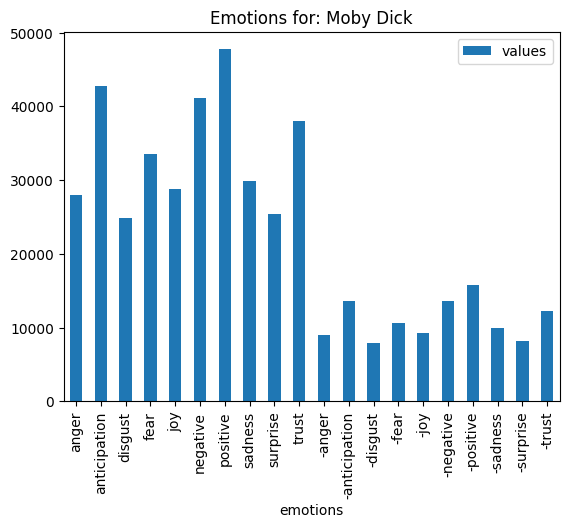

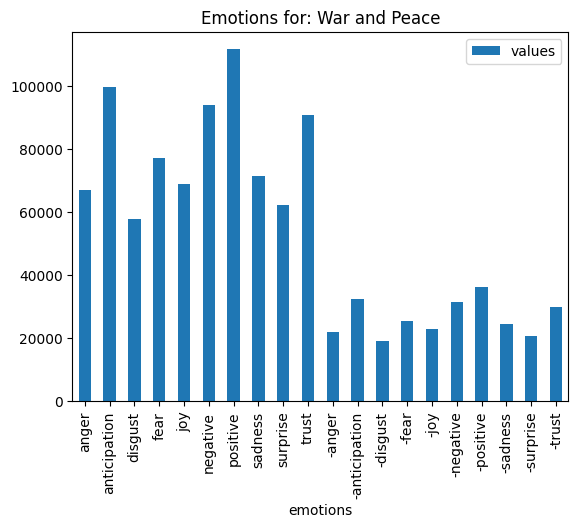

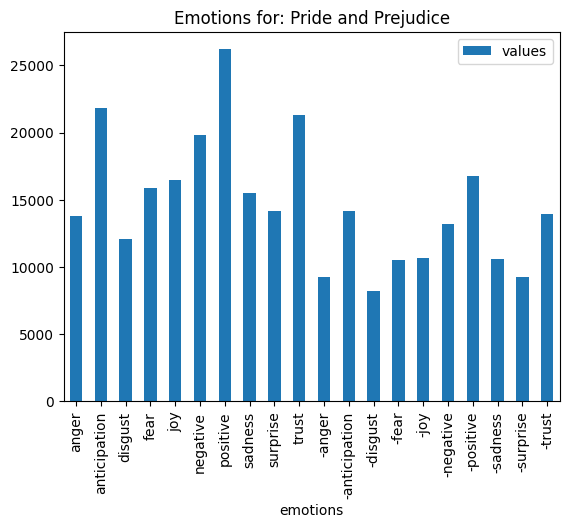

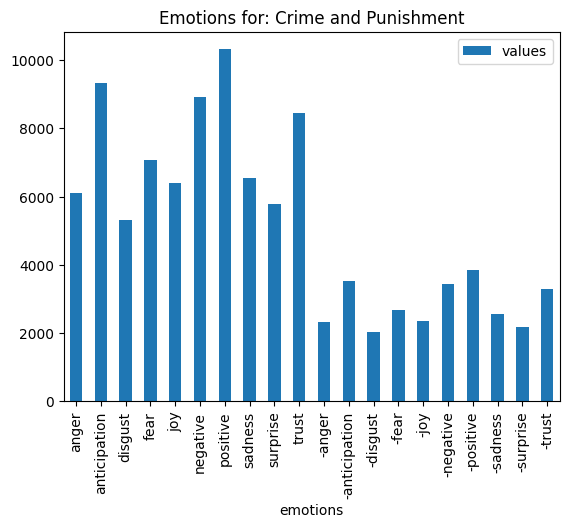

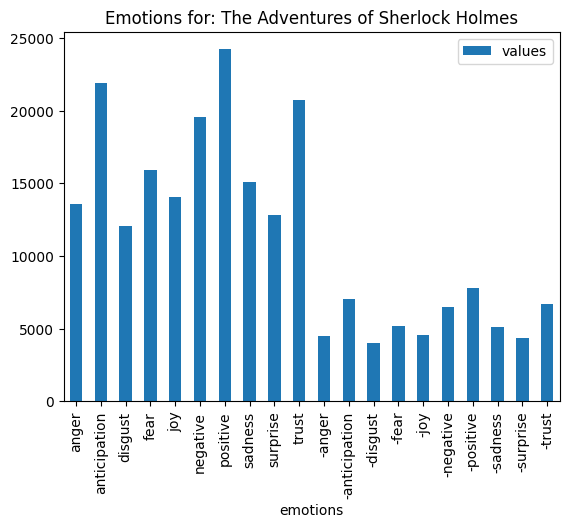

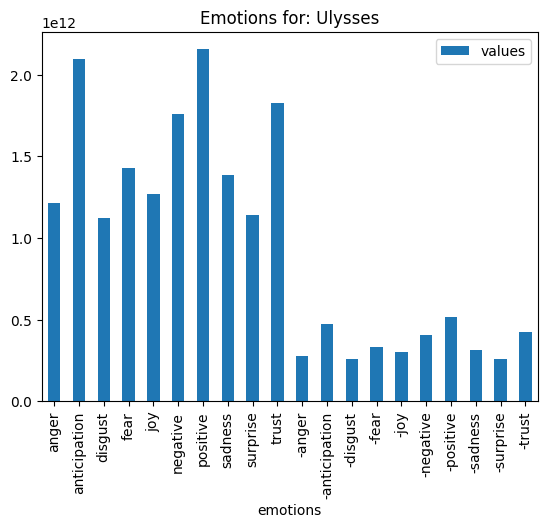

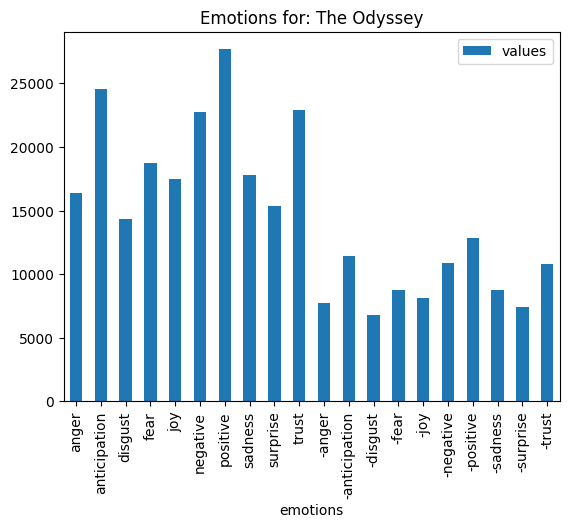

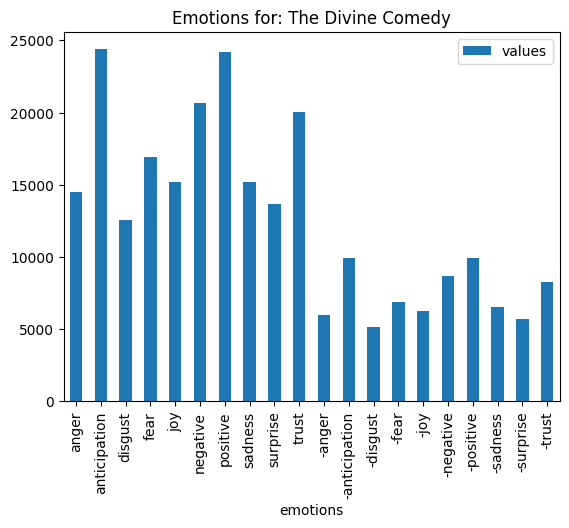

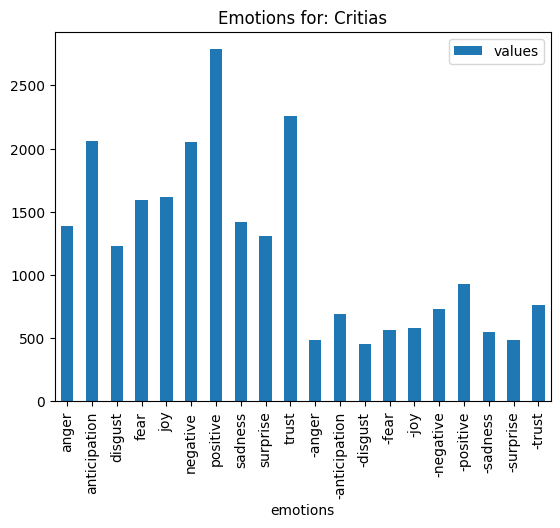

In [27]:

for book in books.keys():
    dataFrame = pd.DataFrame(analisis_libros[book].items(), columns=["emotions", "values"])
    dataFrame.head()
    dataFrame.plot(kind= "bar", x="emotions", y="values", title= f"Emotions for: {book}")
